Vítejte u domácí úlohy do SUI.
V rámci úlohy Vás čeká několik cvičení, v nichž budete doplňovat poměrně malé fragmenty kódu, místo na ně je vyznačené jako `pass` nebo `None`.
Pokud se v buňce s kódem již něco nachází, využijte/neničte to.
V dvou případech se očekává textová odpověď, tu uvedete přímo do zadávající buňky.
Buňky nerušte ani nepřidávejte.

Maximálně využívejte `numpy` a `torch` pro hromadné operace na celých polích.
S výjimkou generátoru minibatchí by se nikde neměl objevit cyklus jdoucí přes jednotlivé příklady.

U všech cvičení je uveden počet bodů za funkční implementaci a orientační počet potřebných řádků.
Berte ho prosím opravdu jako orientační, pozornost mu věnujte pouze, pokud ho významně překračujete.
Mnoho zdaru!

# Informace o vzniku řešení
Vyplňte následující údaje **(3 údaje, 0 bodů)**

* Jméno autora: Dominik Harmim
* Login autora: xharmi00
* Datum vzniku: 31.10.2020

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import scipy.stats

# just for type hints
from typing import Tuple, Iterable, List

# Přípravné práce
Prvním úkolem v této domácí úloze je načíst data, s nimiž budete pracovat.
Vybudujte jednoduchou třídu, která se umí zkonstruovat z cesty k negativním a pozitivním příkladům, a bude poskytovat:

* pozitivní a negativní příklady (`dataset.pos`, `dataset.neg` o rozměrech [N, 7]),
* všechny příklady a odpovídající třídy (`dataset.xs` o rozměru [N, 7], `dataset.targets` o rozměru [N]).

K načítání dat doporučujeme využít `np.loadtxt()`.
Netrapte se se zapouzdřováním a gettery, berte třídu jako Plain Old Data.

Načtěte trénovací (`{positives, negatives}.trn`), validační (`{positives, negatives}.val`) a testovací (`{positives, negatives}.tst`) dataset, pojmenujte je po řadě (`train_dataset`, `val_dataset`, `test_dataset`). 

**(6 + 3 řádků, 1 bod)** 


In [2]:
class Dataset:
    def __init__(self, pos: str, neg: str) -> None:
        super().__init__()
        self.pos = np.loadtxt(pos, dtype=float, delimiter=' ')
        self.neg = np.loadtxt(neg, dtype=float, delimiter=' ')
        self.xs = np.concatenate((self.pos, self.neg))
        self.targets = np.concatenate(
            (np.repeat(1, len(self.pos)), np.repeat(0, len(self.neg)))
        )

train_dataset = Dataset('positives.trn', 'negatives.trn')
val_dataset = Dataset('positives.val', 'negatives.val')
test_dataset = Dataset('positives.tst', 'negatives.tst')

print('positives', train_dataset.pos.shape)
print('negatives', train_dataset.neg.shape)
print('xs', train_dataset.xs.shape)
print('targets', train_dataset.targets.shape)

positives (2280, 7)
negatives (6841, 7)
xs (9121, 7)
targets (9121,)


V řadě následujících cvičení budete pracovat s jedním konkrétním příznakem. Naimplementujte pro začátek funkci, která vykreslí histogram rozložení pozitivních a negativních příkladů (`plt.hist()`). Nezapomeňte na legendu, ať je v grafu jasné, které jsou které. Funkci zavolejte dvakrát, vykreslete histogram příznaku `5` -- tzn. šestého ze sedmi -- pro trénovací a validační data **(5 řádků, 1 bod)**.

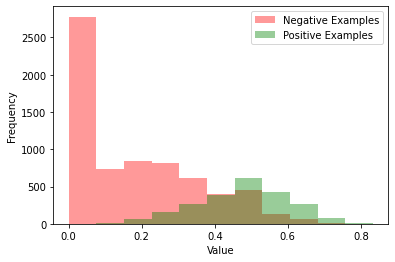

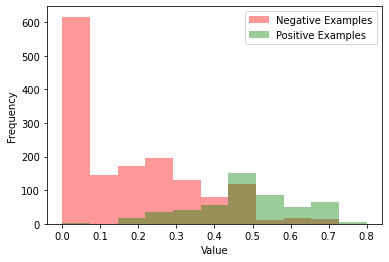

In [3]:
FOI = 5  # Feature Of Interest

def plot_data(poss: np.ndarray, negs: np.ndarray) -> None:
    plt.hist(
        (poss, negs), bins=11, alpha=.4, histtype='stepfilled',
        color=('green', 'red'),
        label=('Positive Examples', 'Negative Examples')
    )
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

plot_data(train_dataset.pos[:, FOI], train_dataset.neg[:, FOI])
plot_data(val_dataset.pos[:, FOI], val_dataset.neg[:, FOI])

## Evaluace klasifikátorů
Než přistoupíte k tvorbě jednotlivých klasifikátorů, vytvořte funkci pro jejich vyhodnocování.
Nechť se jmenuje `evaluate` a přijímá po řadě klasifikátor, pole dat (o rozměrech [N] nebo [N, F]) a pole tříd ([N]).
Jejím výstupem bude _přesnost_, tzn. podíl správně klasifikovaných příkladů.

Předpokládejte, že klasifikátor poskytuje metodu `.prob_class_1(data)`, která vrací pole posteriorních pravděpodobností třídy 1 (tj. $p(y = 1\, |\, x)$) pro daná data.
Evaluační funkce bude muset provést tvrdé prahování (na hodnotě 0.5) těchto pravděpodobností a srovnání získaných rozhodnutí s referenčními třídami.
Využijte fakt, že `numpy`ovská pole lze mj. porovnávat mezi sebou i se skalárem.

**(3 řádky, 1 bod)**

In [4]:
def evaluate(classifier: object, inputs: np.ndarray,
             targets: np.ndarray) -> float:
    y = (classifier.prob_class_1(inputs) > .5).astype(int)
    same_values = (y == targets).astype(int)
    return np.mean(same_values)

class Dummy:
    def prob_class_1(self, xs: np.ndarray) -> np.ndarray:
        return np.asarray([.2, .7, .7])

# should be 0.66...
print(evaluate(Dummy(), np.asarray([]), np.asarray([0, 0, 1])))

0.6666666666666666


## Baseline
Vytvořte klasifikátor, který ignoruje vstupní hodnotu dat.
Jenom v konstruktoru dostane třídu, kterou má dávat jako tip pro libovolný vstup.
Nezapomeňte, že jeho metoda `.prob_class_1(data)` musí vracet pole správné velikosti, využijte `np.ones` nebo `np.full`.

**(4 řádky, 1 bod)**

In [5]:
class PriorClassifier:
    def __init__(self, t: int) -> None:
        super().__init__()
        self.__t = t

    def prob_class_1(self, xs: np.ndarray) -> np.ndarray:
        return np.full(len(xs), self.__t, dtype=float)

baseline = PriorClassifier(0)
val_acc = evaluate(baseline, val_dataset.xs[:, FOI], val_dataset.targets)

print('Baseline val acc:', val_acc)

Baseline val acc: 0.75


# Generativní klasifikátory
V této  části vytvoříte dva generativní klasifikátory, oba založené na Gaussovu rozložení pravděpodobnosti.

Začněte implementací funkce, která pro daná 1-D data vrátí Maximum Likelihood odhad střední hodnoty a směrodatné odchylky Gaussova rozložení, které data modeluje.
Funkci využijte pro natrénovaní dvou modelů: pozitivních a negativních příkladů.
Získané parametry -- tzn. střední hodnoty a směrodatné odchylky -- vypište.

**(5 řádků, 0.5 bodu)**

In [6]:
def gauss_ml_params(xs: np.ndarray) -> Tuple[float, float]:
    return np.mean(xs, dtype=float), np.std(xs, dtype=float)

train_pos_mean, train_pos_std = gauss_ml_params(train_dataset.pos[:, FOI])
train_neg_mean, train_neg_std = gauss_ml_params(train_dataset.neg[:, FOI])

print(f'Positive Examples - Mean: {train_pos_mean}')
print(f'Positive Examples - Standard Deviation: {train_pos_std}')
print(f'Negative Examples - Mean: {train_neg_mean}')
print(f'Negative Examples - Standard Deviation: {train_neg_std}')

Positive Examples - Mean: 0.478428821613158
Positive Examples - Standard Deviation: 0.12971703647258465
Negative Examples - Mean: 0.17453641132613792
Negative Examples - Standard Deviation: 0.17895975196381242


Ze získaných parametrů vytvořte `scipy`ovská gaussovská rozložení `scipy.stats.norm`.
S využitím jejich metody `.pdf()` vytvořte graf, v němž srovnáte skutečné a modelové rozložení pozitivních a negativních příkladů.
Rozsah x-ové osy volte od -0.5 do 1.5 (využijte `np.linspace`) a u volání `plt.hist()` nezapomeňte nastavit `density=True`, aby byl histogram normalizovaný a dal se srovnávat s modelem.

**(2 + 8 řádků, 1 bod)**

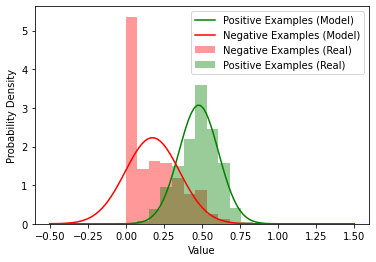

In [7]:
train_pos_norm = scipy.stats.norm(loc=train_pos_mean, scale=train_pos_std)
train_neg_norm = scipy.stats.norm(loc=train_neg_mean, scale=train_neg_std)

xs = np.linspace(-.5, 1.5, 100)
plt.plot(
    xs, train_pos_norm.pdf(xs), color='green',
    label='Positive Examples (Model)'
)
plt.plot(
    xs, train_neg_norm.pdf(xs), color='red',
    label='Negative Examples (Model)'
)
plt.hist(
    (train_dataset.pos[:, FOI], train_dataset.neg[:, FOI]), bins=11,
    density=True, color=('green', 'red'), alpha=.4, histtype='stepfilled',
    label=('Positive Examples (Real)', 'Negative Examples (Real)')
)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.show()

Naimplementujte binární generativní klasifikátor. 
Při konstrukci přijímá dvě rozložení poskytující metodu `.pdf()` a odpovídající apriorní pravděpodobnost tříd.
Jako všechny klasifikátory v této domácí úloze poskytuje metodu `prob_class_1()`.

**(9 řádků, 2 body)**

In [8]:
class GaussClassifier:
    def __init__(self, norms: Tuple[object, object], 
                 priors: Tuple[float, float]) -> None:
        super().__init__()
        self.__norms = norms
        self.__priors = priors

    def prob_class_1(self, xs: np.ndarray) -> np.ndarray:
        pdf_pos, pdf_neg = self.__norms[0].pdf(xs), self.__norms[1].pdf(xs)
        prior_pos, prior_neg = self.__priors
        product = pdf_pos * prior_pos
        return product / (product + pdf_neg * prior_neg)

Nainstancujte dva generativní klasifikátory: jeden s rovnoměrnými priory a jeden s apriorní pravděpodobností 0.75 pro třídu 0 (negativní příklady).
Pomocí funkce `evaluate()` vyhodnoťte jejich úspěšnost na validačních datech.

**(2 řádky, 1 bod)**

In [9]:
classifier_flat_prior = GaussClassifier(
    (train_pos_norm, train_neg_norm), (.5, .5)
)
classifier_full_prior = GaussClassifier(
    (train_pos_norm, train_neg_norm), (.25, .75)
)

print('flat:', evaluate(
    classifier_flat_prior, val_dataset.xs[:, FOI], val_dataset.targets
))
print('full:', evaluate(
    classifier_full_prior, val_dataset.xs[:, FOI], val_dataset.targets
))

flat: 0.809
full: 0.8475


Vykreslete průběh posteriorní pravděpodobnosti třídy 1 jako funkci příznaku 5 pro oba klasifikátory, opět v rozsahu $<-0.5; 1.5>$.
Do grafu zakreslete i histogramy rozložení trénovacích dat, opět s `density=True` pro zachování dynamického rozsahu.

**(8 řádků, 1 bod)**

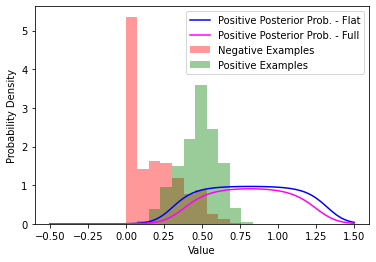

In [10]:
xs = np.linspace(-.5, 1.5, 100)
plt.plot(
    xs, classifier_flat_prior.prob_class_1(xs), color='blue',
    label='Positive Posterior Prob. - Flat'
)
plt.plot(
    xs, classifier_full_prior.prob_class_1(xs), color='magenta',
    label='Positive Posterior Prob. - Full'
)
plt.hist(
    (train_dataset.pos[:, FOI], train_dataset.neg[:, FOI]), bins=11,
    density=True, color=('green', 'red'), alpha=.4, histtype='stepfilled',
    label=('Positive Examples', 'Negative Examples')
)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.show()

Interpretujte, přímo v této textové buňce, každou rozhodovací hranici, která je v grafu patrná **(3 věty, 2 body)**:

Jedna rozhodovací hranice je vidět kolem bodu 0.3. Tady začíná být vyšší pravděpodobnost, že daná hodnota patří do třídy 1. U `Full` klasifikátoru je pravděpodobnost toho, že hodnota v tomto bodě patří do třídy 1 o něco měnší, což je způsobené tím, že tento klasifikátor má vyšší apriorní pravděpodobnost třídy 0. Druhá rozhodovací hranice je kolem bodu 1.3. Zde začíná být nižší pravděpodobnost, že daná hodnota patří do třídy 1. Je to způsobeno tím, že funkce hustoty rozdělení pravděpodobnosti pro třídu 1 je "vyšší" a klesá rychleji. U `Full` klasifikátoru je daná pravděpodobnost opět o něco menší z analogických důvodů jako v předchozím případě.

# Diskriminativní klasifikátory
V následující části budete přímo modelovat posteriorní pravděpodobnost třídy 1.
Modely budou založeny na PyTorchi, ten si prosím nainstalujte.
GPU rozhodně nepotřebujete, veškeré výpočty budou velmi rychlé, ne-li bleskové.

Do začátku máte poskytnutou třídu klasifikátoru z jednoho příznaku.

In [11]:
import torch
import torch.nn.functional as F

class LogisticRegression(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.__w = torch.nn.parameter.Parameter(torch.FloatTensor([1.]))
        self.__b = torch.nn.parameter.Parameter(torch.FloatTensor([0.]))

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return torch.sigmoid(self.__w * x + self.__b)

    def prob_class_1(self, x: np.ndarray) -> np.ndarray:
        prob = self(torch.FloatTensor(x))
        return prob.detach().numpy()

Pro trénovaní diskriminativních modelů budete potřebovat minibatche.
Implementujte funkci, která je bude z daných vstupních a cílových hodnot vytvářet.
Výsledkem musí být možno iterovat, ideálně funkci napište jako generátor (využijte klíčové slovo `yield`).
Jednotlivé prvky výstupu budou dvojice PyTorchových `FloatTensor`ů (musíte zkonvertovat z numpy a nastavit typ) -- první prvek vstupní data, druhý očekávané výstupy.
Počítejte s tím, že vstup bude `numpy`ovské pole, rozumná implementace využije `np.random.permutation()` a [Advanced Indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).

Připravený kód funkci použije na konstrukci tří minibatchí pro trénování identity, měli byste vidět celkem pět prvků náhodně uspořádaných do dvojic, ovšem s tím, že s sebou budou mít odpovídající výstupy.

**(6 řádků, 2 body)**

In [12]:
def batch_provider(xs: np.ndarray, targets: np.ndarray, batch_size: int=10
                  ) -> Iterable[Tuple[torch.FloatTensor, torch.FloatTensor]]:
    idx = np.random.permutation(range(len(xs)))
    for i in range(0, len(xs), batch_size):
        x = torch.FloatTensor(xs[idx[i:i + batch_size]])
        t = torch.FloatTensor(targets[idx[i:i + batch_size]])
        yield x, t

inputs = np.asarray([1., 2., 3., 4., 5.])
targets = np.asarray([1., 2., 3., 4., 5.])
for x, t in batch_provider(inputs, targets, 2):
    print(f'x: {x}, t: {t}')

x: tensor([3., 4.]), t: tensor([3., 4.])
x: tensor([2., 1.]), t: tensor([2., 1.])
x: tensor([5.]), t: tensor([5.])


Dalším krokem je implementovat funkci, která model vytvoří a natrénuje.
Jejím výstupem bude (1) natrénovaný model, (2) průběh trénovací loss a (3) průběh validační přesnosti.
Jako model vracejte ten, který dosáhne nejlepší validační přesnosti.
Jako loss použijte binární cross-entropii (`F.binary_cross_entropy()`), akumulujte ji přes minibatche a logujte průměr.
Pro výpočet validační přesnosti využijte funkci `evaluate()`.
Oba průběhy vracejte jako obyčejné seznamy.

V implementaci budete potřebovat dvě zanořené smyčky: jednu pro epochy (průchody přes celý dataset) a uvnitř druhou, která bude iterovat přes jednotlivé minibatche.
Na konci každé epochy vyhodnoťte model na validačních datech.
K datasetům (trénovacímu a validačnímu) přistupujte bezostyšně jako ke globálním proměnným.

**(cca 14 řádků, 3 body)**

In [13]:
def train_single_fea_llr(fea_no: int, nb_epochs: int, lr: float,
                         batch_size: int) -> Tuple[LogisticRegression, 
                                                   List[float], List[float]]:
    ''' fea_no -- which feature to train on
        nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    global train_dataset, val_dataset

    model = LogisticRegression()
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for _ in range(nb_epochs):
        loss = .0
        batches = batch_provider(
            train_dataset.xs[:, fea_no], train_dataset.targets, batch_size
        )
        for i, (x, t) in enumerate(batches, 1):
            optimizer.zero_grad()
            y = model(x)
            entropy = F.binary_cross_entropy(y, t)
            entropy.backward()
            optimizer.step()
            loss += entropy.item()

        losses.append(loss / i)
        with torch.no_grad():
            acc = evaluate(
                model, val_dataset.xs[:, fea_no], val_dataset.targets
            )
        if not accuracies or acc > max(accuracies):
            best_model = copy.deepcopy(model)
        accuracies.append(acc)

    return best_model, losses, accuracies

Funkci zavolejte a natrénujte model.
Uveďte zde parametry, které vám dají slušný výsledek.
Měli byste dostat přesnost srovnatelnou s generativním klasifikátorem s nastavenými priory.
Neměli byste potřebovat víc než 100 epoch.
Vykreslete průběh trénovací loss a validační přesnosti, osu x značte v epochách.

V druhém grafu vykreslete histogramy trénovacích dat a pravděpodobnost třídy 1 pro x od -0.5 do 1.5, podobně jako výše u generativních klasifikátorů.
Při výpočtu výstupů využijte `with torch.no_grad():`.

**(1 + 6 + 9 řádků, 1 bod)**

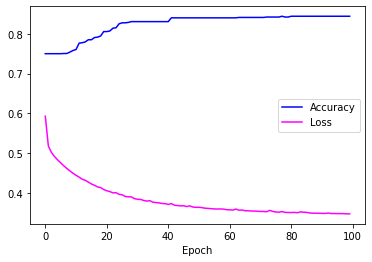

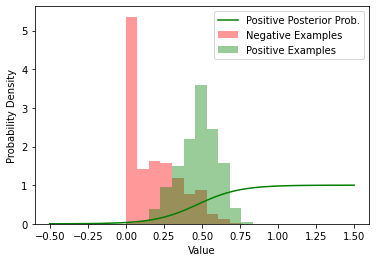

In [14]:
classifier_llr_single_fea, losses, accuracies = \
    train_single_fea_llr(FOI, 100, .01, 20)

plt.plot(accuracies, color='blue', label='Accuracy')
plt.plot(losses, color='magenta', label='Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

xs = np.linspace(-.5, 1.5, 100)
with torch.no_grad():
    plt.plot(
        xs, classifier_llr_single_fea.prob_class_1(xs), color='green',
        label='Positive Posterior Prob.'
    )
plt.hist(
    (train_dataset.pos[:, FOI], train_dataset.neg[:, FOI]), bins=11,
    density=True, color=('green', 'red'), alpha=.4, histtype='stepfilled',
    label=('Positive Examples', 'Negative Examples')
)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.show()

## Všechny vstupní příznaky
V posledním cvičení natrénujete logistickou regresi, která využije všech sedm vstupních příznaků.

Prvním krokem je naimplementovat příslusný model.
Bezostyšně zkopírujte tělo třídy `LogisticRegresion` a upravte ji tak, aby zvládala libovolný počet vstupů, využijte `torch.nn.Linear`.
U výstupu metody `.forward()` dejte pozor, aby měl výstup tvar `[N]`; pravděpodobně budete potřebovat `squeeze`.

**(9 řádků, 1 bod)**

In [15]:
class FullLogisticRegression(torch.nn.Module):
    def __init__(self, nb_features: int) -> None:
        super().__init__()
        self.__m = torch.nn.Linear(nb_features, 1)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        return torch.squeeze(torch.sigmoid(self.__m(x)))

    def prob_class_1(self, x: np.ndarray) -> np.ndarray:
        prob = self(torch.FloatTensor(x))
        return prob.detach().numpy()

Podobně jako u jednodimenzionálni regrese implementujte funkci pro trénovaní plné logistické regrese.
V ideálním případě vyfaktorujete společnou implementaci, které budete pouze předávat různá trénovací a validační data.

Zvídaví mohou zkusit `Adam`a jako optimalizátor namísto obyčejného `SGD`.

Funkci zavolejte, natrénujte model.
Opět vykreslete průběh trénovací loss a validační přesnosti.
Měli byste se s přesností dostat nad 90 %.

**(ne víc než cca 30 řádků při kopírování, 1 bod)**

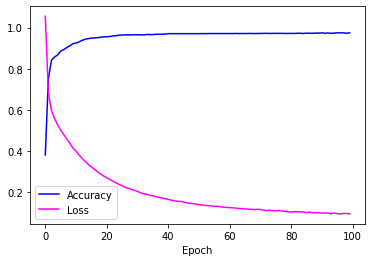

In [16]:
def train_full_llr(nb_epochs: int, lr: float, batch_size: int
                  ) -> Tuple[FullLogisticRegression, List[float], List[float]]:
    ''' nb_epochs -- how many times to go through the full training data
        lr -- learning rate
        batch_size -- size of minibatches
    '''
    global train_dataset, val_dataset

    model = FullLogisticRegression(train_dataset.xs.shape[1])
    best_model = copy.deepcopy(model)
    losses = []
    accuracies = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
       
    for _ in range(nb_epochs):
        loss = .0
        batches = batch_provider(
            train_dataset.xs, train_dataset.targets, batch_size
        )
        for i, (x, t) in enumerate(batches, 1):
            optimizer.zero_grad()
            y = model(x)
            entropy = F.binary_cross_entropy(y, t)
            entropy.backward()
            optimizer.step()
            loss += entropy.item()

        losses.append(loss / i)
        with torch.no_grad():
            acc = evaluate(model, val_dataset.xs, val_dataset.targets)
        if not accuracies or acc > max(accuracies):
            best_model = copy.deepcopy(model)
        accuracies.append(acc)

    return best_model, losses, accuracies

classifier_llr_full, losses, accuracies = train_full_llr(100, .005, 600)

plt.plot(accuracies, color='blue', label='Accuracy')
plt.plot(losses, color='magenta', label='Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

# Závěrem
Konečně vyhodnoťte všech pět vytvořených klasifikátorů na testovacích datech. Stačí doplnit jejich názvy a předat jim příznaky, na které jsou zvyklé.

**(0.5 bodu)**

In [17]:
xs_full = test_dataset.xs
xs_foi = test_dataset.xs[:, FOI]
targets = test_dataset.targets

print('Baseline:', evaluate(baseline, xs_foi, targets))
print('Generative classifier (w/o prior):',
      evaluate(classifier_flat_prior, xs_foi, targets))
print('Generative classifier (correct):',
      evaluate(classifier_full_prior, xs_foi, targets))
print('Logistic regression:',
      evaluate(classifier_llr_single_fea, xs_foi, targets))
print('Logistic regression all features:',
      evaluate(classifier_llr_full, xs_full, targets))

Baseline: 0.75
Generative classifier (w/o prior): 0.8
Generative classifier (correct): 0.847
Logistic regression: 0.853
Logistic regression all features: 0.9685


Blahopřejeme ke zvládnutí domácí úlohy! Notebook spusťte načisto (Kernel -> Restart & Run all), vyexportuje jako PDF a odevzdejte pojmenovaný svým loginem.

Mimochodem, vstupní data nejsou synteticky generovaná. Nasbírali jsme je z projektu; Vaše klasifikátory v této domácí úloze predikují, že daný hráč vyhraje; takže by se daly použít jako heuristika pro ohodnocování listových uzlů ve stavovém prostoru hry.
Pro představu, odhadujete to z pozic pět kol před koncem partie pro daného hráče.
Poskytnuté příznaky popisují globální charakteristiky stavu hry jako je například poměr délky hranic předmětného hráče k ostatním hranicím.